In [2]:
import numpy as np
from matplotlib import pyplot as plt

# RBM class implementation with Constrastive Divergence

Restricted Boltzmann Machine (RBM) is an algorithm that is based on the Boltzmann Machine. The idea was proposed by Geoffrey Hinton (2002) and has since been used to tackle many problems successfully, even beating out many advanced feed-forward networks. 

The architecture consists of 1 visible and 1 hidden unit. Every visible unit is linked to every hidden unit, but each hidden unit is independent from one another. The weights that connects the two layers are symmetrical. 

RBM is an unsupervised learning algorithm. There is no target function to minimize. Instead, it is a form of auto-encoder. The weights are adjusted such that the input can be reconstructed accurately. 

There are a number of possible learning method for the RBM. Here I present the most basic learning algorithm, the Contrastive Divergence algorithm. This algorithm compares the reconstructed input after k-steps to the initial input and updates the weight based on this difference. Take note that unlike a feed-forward network, the algorithm is probabilistic in nature. It does not back-propagate any error function to update the weights as there are no error function to evaluate.

To monitor the learning performance, we plot the squared difference between the reconstructed mean and the input, the error function, as well as the weights distribution.

## Class Implementation Details

The idea is based on the programming assignment of the Neural Network Assignment by Geoffrey Hinton on Coursera. Implementation as a class makes it easier to use in future projects and opens much more possibility for method expansions.

The implementation also includes methods to display error and weight histogram to make monitoring of the learning process easier. 

In [355]:
class RBM(object):
    def __init__(self, input = None, n_visible = 1, n_hidden = 1, 
                W = None, hbias = None, vbias = None, numpy_rng = None):
        """
        Creates an RBM model based on the input parameter from a Numpy Array
        
        Matrix Sizes:
        V = sample_size x n_visible
        H = sample_size x n_hidden
        W = n_visible x n_hidden
        
        Parameters:
        input = input matrix for the RBM.
        n_visible = number of visible UNITS. this has to align with the input dimensions
        n_hidden = number of hidden UNITS.
        W = initialized weights matrix. if None, weight will be initialized by the model 
            using a uniform distribution that is proportional to n_visible
        h_vias = hidden unit bias vector
        v_bias = visible unit bias vector
        numpy_rng = random seed to ensure consistency in calculation. 
                    if left as None, random seed will be intialized by the model
            
        """
        self.n_visible = n_visible #num of visible unit
        self.n_hidden = n_hidden #num of hidden unit
        
        if numpy_rng is None:
            numpy_rng = np.random.RandomState(123)
            
        if W is None:
            a = 1. / n_visible
            initial_W = np.array(numpy_rng.uniform(
                        low = -a, 
                        high = a, 
                        size = (n_visible, n_hidden)
                            )
                        )
            W = initial_W
        
        sample_size = data.shape[0]
        
        if hbias == None:
            hbias = np.zeros((sample_size,n_hidden))
        
        if vbias == None:
            vbias = np.zeros((sample_size,n_visible))
        
        self.numpy_rng = numpy_rng
        self.hbias = hbias
        self.vbias = vbias
        self.W = W
        self.input = input
        self.energy_plot = []
        self.error_plot = []
        
    def contrastive_divergence(self, lr = 0.1, k = 1):
        """
        Performs contrastive divergence of on the model. 
        
        Parameters:
        lr = learning rate. default = 0.1
        k = number of steps for the CD algorithm. default = 1, i.e. CD1
        
        Outputs:
        energy = energy of the current RBM model after k-steps of input reconstruction
        error = error between reconstructed output after k-steps to the initial input
        """
        ph_mean, ph_sample = self.get_hid_state(self.input)
        
        cur_sample = ph_sample
        
        for step in range(k):
            nv_mean, nv_sample = self.get_vis_state(cur_sample)
            nh_mean, nh_sample = self.get_hid_state(nv_sample)
            cur_sample = nh_sample
                
        delta_W = lr * (np.dot(self.input.T, ph_sample) - np.dot(nv_sample.T, nh_sample))

        delta_hbias = lr * np.mean(ph_sample - nh_sample)
        delta_vbias = lr * np.mean(self.input - nv_sample)
        
        self.W += delta_W
        self.hbias += delta_hbias
        self.vbias += delta_vbias
        
        energy = self.get_energy(v = nv_mean, h = nh_mean)
        error = self.get_error(v_init = self.input, v_recon = nv_mean)
        
        return [energy, error]
        
    def propup(self, v):
        z = np.dot(v, self.W) + self.hbias
        return self.sigmoid(z)
    
    def propdown(self, h):
        z = np.dot(self.W, h.T).T + self.vbias
        return self.sigmoid(z)
    
    def get_hid_state(self, v_sample):
        h_mean = self.propup(v_sample)
        h_sample = self.numpy_rng.binomial(size = h_mean.shape, 
                                            n = 1, #bernoulli distribution
                                            p = h_mean)
        return [h_mean, h_sample]
    
    def get_vis_state(self, h_sample):
        v_mean = self.propdown(h_sample)
        v_sample = self.numpy_rng.binomial(size = v_mean.shape, 
                                            n = 1, 
                                            p = v_mean)
        return [v_mean, v_sample]
      
    def get_energy(self, v = None, h = None): 
        energy = -np.sum(np.multiply(np.dot(v.T, h), self.W)) - np.sum(np.dot(self.vbias, v.T)) - np.sum(np.dot(self.hbias, h.T))
        return energy
    
    def get_error(self, v_init = None, v_recon = None):
        error = np.sum(np.square(v_init - v_recon))
        return error
        
    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    
    def train(self, n_epoch = 1000, lr = 0.1, k = 1):
        """
        Training function. Calculates contrastive divergence to update the weight
        and stores energy and error values
        
        Paramters:
        n_epoch = number of epoch. default = 1000
        lr = learning rate. default = 0.1
        k = CD step number. default = 1    
        """
        for epoch in range(n_epoch):
            energy, error = self.contrastive_divergence(lr = lr/(epoch+1), k = k)
            self.energy_plot.append(energy)
            self.error_plot.append(error)
            if (epoch + 1) % 100 == 0:
                print('training epoch %s, energy is %s, error is %s' % (epoch + 1, energy, error))
                
    
    def plot_energy(self, n_window = 100):
        """
        Plots an energy function of the model.
        Useful metric to use to monitor learning process.
        
        Parameters:
        n_window = the window size for moving average of the model. 
        """
        energy_plot = []
        cumsum = [0]
        for i, energy in enumerate(self.energy_plot):
            cumsum.append(cumsum[i-1] + energy)
            if i >= n_window:
                moving_ave = (cumsum[i] - cumsum[i - n_window])/n_window
                energy_plot.append(moving_ave)
            
        plt.plot(energy_plot)
        plt.show()
        
    def plot_error(self, n_window = 100):
        """
        Plots the sum of squared error between the reconstructed input and the original input.
        Useful metric to use to monitor learning process.
        
        Parameters:
        n_window = the window size for moving average of the model. 
        """
        error_plot = []
        cumsum = [0]
        for i, error in enumerate(self.error_plot):
            cumsum.append(cumsum[i - 1] + error)
            if i >= n_window:
                moving_ave = (cumsum[i] - cumsum[i-n_window])/n_window
                error_plot.append(moving_ave)
        
        plt.plot(error_plot)
        plt.show()
    
    def disp_weights(self, n_bins = 10):
        """
        Debugging function to show the weights distribution
        Useful metric to use to monitor learning process.
        """
        #print(self.W)
        plt.hist(self.W.reshape((self.n_visible * self.n_hidden, 1)), bins = n_bins)
        plt.show()
    
    def predict(self, input = None):
        if input is None:
            input = self.input
        hid_mean, hid_state = self.get_hid_state(input)
        vis_mean, vis_state = self.get_vis_state(hid_state)

        plt.subplot(231)
        plt.imshow(input)
        plt.title("original")
        plt.subplot(232)
        plt.imshow(vis_state)
        plt.title("reconstructed")
        plt.subplot(233)
        plt.imshow(vis_mean)
        plt.title("recon mean")
        
        plt.subplot(234)
        plt.imshow(self.W)
        plt.title("weights")
        plt.show()

In [437]:
data = np.array([[1,1,1,0,0,0],
                 [1,0,1,0,0,0],
                 [1,1,1,1,1,1],
                 [0,0,0,1,0,1],
                 [0,0,0,1,1,1],])
rng = np.random.RandomState(123)
n_visible = data.shape[1]
n_hidden = 10
W = rng.normal(size = (n_visible, n_hidden))

In [455]:
rbm = RBM(input = data, n_visible = n_visible, n_hidden = n_hidden, W = W, numpy_rng = rng)

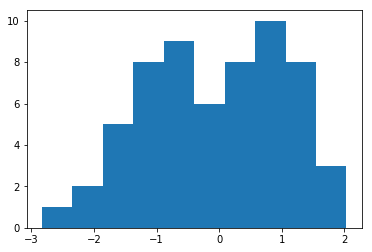

In [456]:
rbm.disp_weights()

In [468]:
rbm.train(lr = 0.1, k = 1, n_epoch = 1000)

training epoch 100, energy is -49.87504645642065, error is 1.7558058116287663
training epoch 200, energy is -56.39735002774035, error is 0.9526946249830063
training epoch 300, energy is -55.06865913294473, error is 1.4809316782782092
training epoch 400, energy is -54.27309043384027, error is 1.6264444417513715
training epoch 500, energy is -53.19034898218938, error is 3.6411979305115905
training epoch 600, energy is -48.109609818081125, error is 0.8206799885219086
training epoch 700, energy is -50.08877263842787, error is 1.935783404850022
training epoch 800, energy is -54.82986067303868, error is 1.4359522136567342
training epoch 900, energy is -51.18396184246062, error is 1.9068697724822028
training epoch 1000, energy is -52.479345633964996, error is 0.8545725999714212


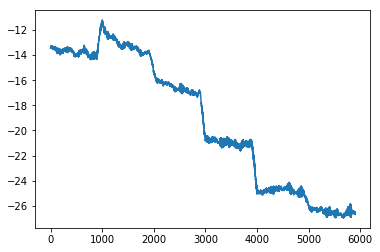

In [469]:
rbm.plot_energy()

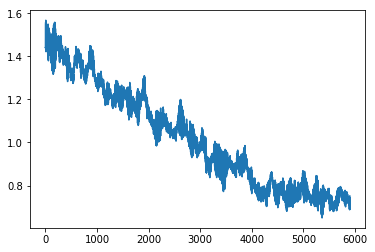

In [471]:
rbm.plot_error()

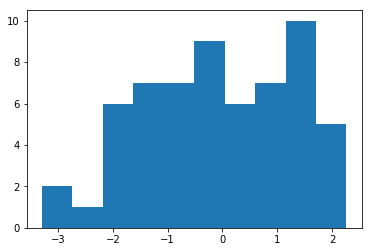

In [470]:
rbm.disp_weights()

## Results of the RBM with CD algorithm

Due to the crude nature of CD learning algorithm whereby the model is restarted to the initial point at every step of the learning, the model term of the weight update expression is too far from the ideal model parameter. This can be seeen from the reconstructed result compared to the initial input below.

In the next section I will improve on this using the Persistent Contastive Divergence method.

In [472]:
vali = np.array([[1,0,1,0,0,1],
                 [1,0,1,0,0,1],
                 [1,1,1,0,0,1],
                 [0,0,1,1,1,1],
                 [0,0,0,0,0,0],])

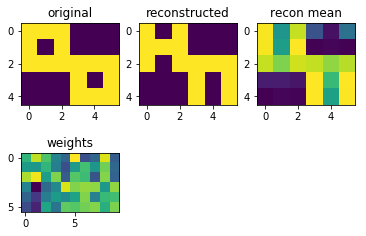

In [473]:
rbm.predict()

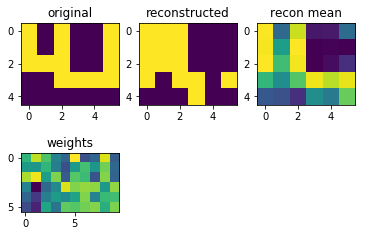

In [474]:
rbm.predict(input = vali)

# RBM with Persistent CD algorithm

Persistent Contrastive Divergence is a variant of the contrastive divergence algorithm illustrated above. However, instead of restarting the Markov Chain everytime the contrastive divergence, we allow the Markov Chain to run continuously. This is achieved by having the result of the previous Chain stored and used in the next chain. 

By having the Chain run continously, the model is able to move much further along the model space than traditional Contrastive Divergence. As a result, with subsequent iteration, the configuration gets closer to the ideal equilibrium configuration, making the reconstruction much more accurate. 


In [517]:
class RBM_PCD (RBM):
    def __init__(self, input = None, n_visible = 1, n_hidden = 1, 
                W = None, hbias = None, vbias = None, numpy_rng = None):
        RBM.__init__(self, input, n_visible, n_hidden, W, hbias, vbias, numpy_rng)
        
        self.V_mean, self.V_persistent = np.zeros(self.input.shape), self.input
        self.H_mean, self.H_persistent = self.get_hid_state(self.V_persistent)
        
    def PCD (self, lr = 0.01, k = 1, wd = 0.9):
        """
        Updates weight using PCD algorithm. 
        
        Parameters:
        lr = Learning Rate
        k = CD step to take before weight update
        
        Output:
        error = squared error between reconstructed input and actual input
        energy = energy of the reconstructed model
        """
        ph_mean, ph_sample = self.get_hid_state(self.input)
        
        for step in range(k):
            self.V_mean, self.V_persistent = self.get_vis_state(self.H_persistent)
            self.H_mean, self.H_Persistent = self.get_hid_state(self.V_persistent)
                
        delta_W = lr * (np.dot(self.input.T, ph_mean) - np.dot(self.V_mean.T, self.H_mean))

        delta_hbias = lr * np.mean(ph_sample - self.H_mean)
        delta_vbias = lr * np.mean(self.input - self.V_mean)
        
        self.W = wd * (self.W + delta_W)
        self.hbias  = wd * (self.hbias + delta_hbias)
        self.vbias  = wd * (self.vbias + delta_vbias)
        
        energy = self.get_energy(v = self.V_mean, h = self.H_mean)
        error = self.get_error(v_init = self.input, v_recon = self.V_mean)
        
        return [energy, error]
    
    def train(self, n_epoch = 1000, lr = 0.1, k = 1, wd = 0.9):
        for epoch in range(n_epoch):
            energy, error = self.PCD(lr = lr/(epoch + 1), k = k, wd = wd)
            self.energy_plot.append(energy)
            self.error_plot.append(error)
            if (epoch + 1) % 100 == 0:
                print('training epoch %s, energy is %s, error is %s' % (epoch + 1, energy, error))
                
            

In [518]:
data = np.array([[1,1,1,0,0,0],
                 [1,0,1,0,0,0],
                 [1,1,1,1,1,1],
                 [0,0,0,1,0,1],
                 [0,0,0,1,1,1],])
rng = np.random.RandomState(123)
n_visible = data.shape[1]
n_hidden = 10
W = rng.normal(size = (n_visible, n_hidden))

In [519]:
rbm_pcd = RBM_PCD(input = data, n_visible = n_visible, n_hidden = n_hidden, W = W, numpy_rng = rng)

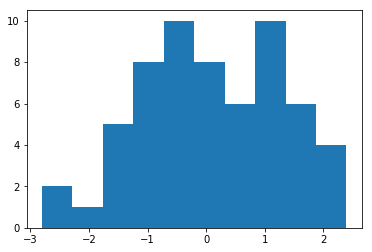

In [520]:
rbm_pcd.disp_weights()

In [541]:
rbm_pcd.train(lr = 0.1, k = 1, n_epoch = 1000, wd = 1)

training epoch 100, energy is -58.128497351161315, error is 2.6136355745706985
training epoch 200, energy is -59.04456659936415, error is 2.6134414349624717
training epoch 300, energy is -61.10651247905598, error is 2.6129618677460633
training epoch 400, energy is -57.50878249769688, error is 2.6126205826324016
training epoch 500, energy is -55.04665701238793, error is 2.6121214003083546
training epoch 600, energy is -57.43974748388045, error is 2.611420686927921
training epoch 700, energy is -61.07473795427564, error is 2.6111364119499596
training epoch 800, energy is -50.94913745141437, error is 2.6111325636333342
training epoch 900, energy is -61.90859631551186, error is 2.610936864186929
training epoch 1000, energy is -58.13688683670485, error is 2.610758147104084


# Results from using RBM with PCD learning algorithm

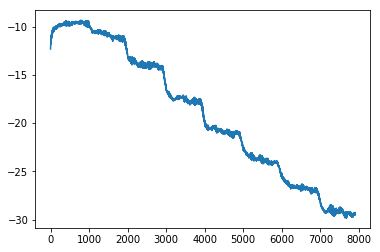

In [542]:
rbm_pcd.plot_energy(100)

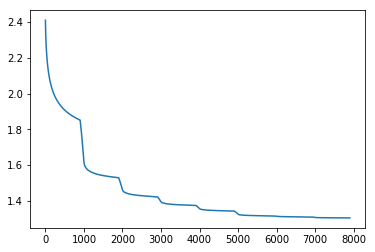

In [543]:
rbm_pcd.plot_error(100)

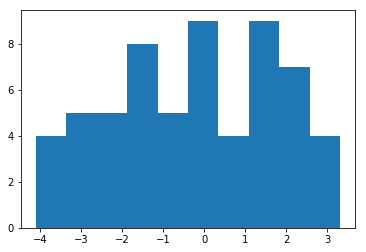

In [544]:
rbm_pcd.disp_weights()

# Results of the RBM learned with PCD

As can be seen, the reconstructed mean resembles the input more compared to when CD1 was used. This comes at the expense of computing power however. For this small toy example, computing power is not big issue. However, as the input data set becomes bigger, learning will take much longer.

In [545]:
vali = np.array([[1,0,1,0,0,1],
                 [1,0,1,0,0,1],
                 [1,1,1,0,0,1],
                 [0,0,1,1,1,1],
                 [0,0,0,0,0,0],])

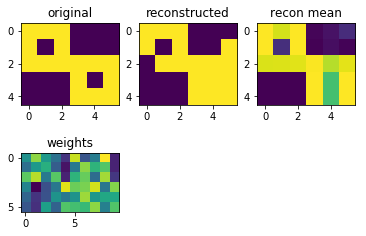

In [546]:
rbm_pcd.predict()

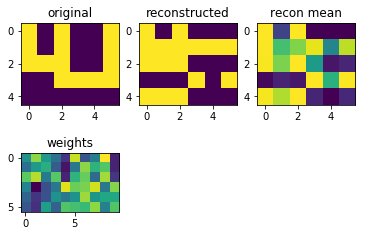

In [551]:
rbm_pcd.predict(input = vali)